In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ％pip install -U networkx

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
# plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [ ]:
# cloab 字體設定
import matplotlib

!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-04-07 03:11:19--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.107.138, 142.251.107.102, 142.251.107.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.107.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-04-07 03:11:19--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.97.132, 2607:f8b0:400c:c18::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.97.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘taipei_sans_tc_beta.ttf’

taipei_sans_tc_beta 100%[===================>]  19.70M  51.5MB/s    in 0.4s    

2024-04-07 03:11:2

## 資料前處理

### 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 旅韓版(Korea_Travel)文章
+ 時間: 2023-06-01 ~ 2023-12-31
+ 資料筆數：共 945 篇文章

In [ ]:
#匯入資料
df = pd.read_csv('/content/drive/MyDrive/social_media_analysis/group_assignments/dataset_train.csv', encoding = 'UTF-8')
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,cici950630,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,[],209.141.52.118,2023-06-02 01:02:07,ptt
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,[分享]長榮哩程機票兌換升等後補時間,2023-06-01,nanna,Aviation,今天八點半準時打長榮客服，聽了很多語音，按了很多按鍵後，\n 按9轉客服，完全沒有等到。\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abyssa1"", ""c...",118.163.43.79,2023-06-02 01:02:07,ptt
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,2023-06-01,Furella,Aviation,圖文網誌版:\nhttps://bitesize.tw/2018-zqn-air-new-z...,[],118.167.224.229,2023-06-02 01:02:07,ptt


### 資料清理
- 去除NA值
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [ ]:
MetaData = df[df.artCatagory == 'Korea_Travel'].copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData = MetaData.dropna(subset=['artContent'])
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...
7123,7124,https://www.ptt.cc/bbs/Korea_Travel/M.16855505...,[徵求]6/16釜山(廣安里)食伴,2023-06-01,Korea_Travel,徵求類別：食伴\n 原PO性別：女， 2n\n 徵 求：6/16 一起在廣安里吃晚餐\...,徵求類別食伴原性別女徵求一起在廣安里吃晚餐內容當天點左右落地住宿在廣安里所以想找當天可以一起...
7124,7125,https://www.ptt.cc/bbs/Korea_Travel/M.16856058...,[徵求]visitbusanpass實體卡24H4張,2023-06-01,Korea_Travel,徵visit busan pass 實體卡\n24H 4張 捷運站可面交 謝謝\n,徵實體卡張捷運站可面交謝謝


### 文章斷詞與整理

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('/content/drive/MyDrive/social_media_analysis/group_assignments/dict.txt.big')

# 新增stopwords
with open('/content/drive/MyDrive/social_media_analysis/group_assignments/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
stopwords_manual = ["一些", "一份", "一台", "一圈", "一堆", "一定", "一家", "一人", "一天", "一小", "一大", "一帶", "一座", "一張", "一旁", "一日", "一早", "一晚", "一杯", "一條", "一次", "一段", "一種", "一起", "一趟", "一路", "一邊", "一間", "三個", "三天", "上次", "上面", "上方", "上點", "下來", "下去", "下方", "下次", "下面", "不到", "不太", "不知", "不算", "中間", "之前", "之外", "之間", "令人", "以來", "以前", "以外", "以為", "似乎", "來說", "像是", "先到", "兩個", "再次", "出現", "則是", "前方", "前面", "剛剛", "十分", "in", "XD", "一下", "一位", "一個", "一半", "一直", "一點", "下午", "不用", "主要", "之後", "今天", "今年", "今日", "他們", "以下", "以後", "來到", "入住", "內容", "出發", "分享", "前往", "包含", "包括", "可能", "吃到", "各位", "名稱", "回到", "因一", "因上", "地方", "好像", "完整", "就是", "層面", "左右", "年前", "年增", "建議", "感覺", "成為", "我們", "打打", "抵達", "持續", "指出", "提供", "搭配", "整個", "方面", "旁邊", "日期", "早上", "明天", "明年", "明日", "昨日", "是否", "晚上", "最後", "月底", "有", "有沒有", "有無", "東西", "決定", "沒", "沒有", "準備", "然後", "特別", "現在", "發現", "發生", "目前", "直接", "相關", "看到", "看看", "知道", "碰到", "維持", "聞到", "聽到", "表示", "裡面", "認為", "謝謝", "這", "這裡", "這間", "造成", "造訪", "進行", "過去", "那裡", "附近", "隔天", "離開", "需要", "顯示"]
stopWords.extend(stopwords_manual)

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [ ]:
MetaData = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
MetaData['word'] = MetaData.sentence.apply(getToken).explode('word')

MetaData.head(3)

Building prefix dict from /content/drive/MyDrive/social_media_analysis/group_assignments/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/social_media_analysis/group_assignments/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u7234afd41a7c8425b71c38621cb87694.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u7234afd41a7c8425b71c38621cb87694.cache
Loading model cost 2.084 seconds.
DEBUG:jieba:Loading model cost 2.084 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,舞技
7123,7124,https://www.ptt.cc/bbs/Korea_Travel/M.16855505...,[徵求]6/16釜山(廣安里)食伴,2023-06-01,Korea_Travel,徵求類別：食伴\n 原PO性別：女， 2n\n 徵 求：6/16 一起在廣安里吃晚餐\...,徵求類別食伴原性別女徵求一起在廣安里吃晚餐內容當天點左右落地住宿在廣安里所以想找當天可以一起...,不太好
7124,7125,https://www.ptt.cc/bbs/Korea_Travel/M.16856058...,[徵求]visitbusanpass實體卡24H4張,2023-06-01,Korea_Travel,徵visit busan pass 實體卡\n24H 4張 捷運站可面交 謝謝\n,徵實體卡張捷運站可面交謝謝,徵求


## 利用tf-idf找出重要詞彙

In [ ]:
travel_df = MetaData.copy()
travel_df.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,舞技
7123,7124,https://www.ptt.cc/bbs/Korea_Travel/M.16855505...,[徵求]6/16釜山(廣安里)食伴,2023-06-01,Korea_Travel,徵求類別：食伴\n 原PO性別：女， 2n\n 徵 求：6/16 一起在廣安里吃晚餐\...,徵求類別食伴原性別女徵求一起在廣安里吃晚餐內容當天點左右落地住宿在廣安里所以想找當天可以一起...,不太好
7124,7125,https://www.ptt.cc/bbs/Korea_Travel/M.16856058...,[徵求]visitbusanpass實體卡24H4張,2023-06-01,Korea_Travel,徵visit busan pass 實體卡\n24H 4張 捷運站可面交 謝謝\n,徵實體卡張捷運站可面交謝謝,徵求


In [ ]:
# 保留需要的欄位
travel_df = travel_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
travel_df['word'] = travel_df.sentence.apply(getToken).map(' '.join)

travel_df.head()

,system_id,sentence,word
7122,7123,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,徵求 類別 行李箱 性別 徵求 拿錯 行李箱 搭乘 行李箱 當日 老婆 晚去 行李 轉盤 行...
7123,7124,徵求類別食伴原性別女徵求一起在廣安里吃晚餐內容當天點左右落地住宿在廣安里所以想找當天可以一起...,徵求 類別 食伴 性別 徵求 廣安 晚餐 當天 落地 住宿 廣安 當天 晚餐 朋友 廣安 更...
7124,7125,徵實體卡張捷運站可面交謝謝,實體 卡張 捷運 面交
7125,7126,桃園大邱單程票不含行李成人張因為朋友臨時不能出行如果真的賣不掉的話就我跟你去可以的話兩張一起...,桃園 大邱 單程票 行李 成人 張因 朋友 臨時 出行 賣不掉 兩張 賣掉 兩張 含稅 預訂...
7126,7127,因為行程異動所以想詢問是否有版友有需求明洞號出口步行約公尺訂的房型是上下舖可入住兩人有獨立衛...,行程 異動 詢問 版友 需求 明洞號 出口 步行 公尺 房型 兩人 獨立 衛浴 原價 預售 ...


In [ ]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(travel_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一下下,一下子,一下首,一不小心,一中,一串,一二,一二三,一人份,...,龍宮,龍山,龍山區,龍平,龍王,龍蝦,龍頭,龍頭山,龐大,龜毛
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
transformer = TfidfTransformer()
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一下下,一下子,一下首,一不小心,一中,一串,一二,一二三,一人份,...,龍宮,龍山,龍山區,龍平,龍王,龍蝦,龍頭,龍頭山,龐大,龜毛
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 檢視結果   
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [ ]:
travel_tfidf = TFIDF_df.mean().to_frame().reset_index()
travel_tfidf.columns = ["word", "avg"]

travel_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
5613,徵求,0.060138
7983,機場,0.033981
13570,釜山,0.031719
14483,首爾,0.030172
5711,性別,0.028493
14331,類別,0.027203
14169,韓國,0.026474
14393,食伴,0.026397
1436,備註,0.024976
1640,內信,0.024586


可以看到除了一些相關的地名之外，有一些徵求、食伴等詞彙，這是因為有許多人在旅韓版上徵伴的關係。

#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [ ]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一下下,一下子,一下首,一不小心,一中,一串,一二,一二三,...,龍宮,龍山,龍山區,龍平,龍王,龍蝦,龍頭,龍頭山,龐大,龜毛
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
13989775,941,龜毛,0.0
13989776,942,龜毛,0.0
13989777,943,龜毛,0.0
13989778,944,龜毛,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [ ]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)

    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
2106,徵求,145
4482,釜山,68
2848,機場,61
4720,食伴,58
0,一一,47
2544,旅伴,46
1549,大邱,45
1,一下下,40
4753,首爾,37
396,仁川,34


由第二個方法的結果可以看出徵求相關詞彙還是存在，但相比第一種方法多了一些韓國的地名。

## 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

### Bigram

In [ ]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]

    return seg_list

In [ ]:
travel_bigram = MetaData.copy()

travel_bigram["word"] = travel_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
travel_bigram = travel_bigram.explode('word')

travel_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,徵求 類別
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,類別 行李箱
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,行李箱 性別


#### 統計最常出現的bigram組合

In [ ]:
# 計算每個組合出現的次數
travel_bigram_count = travel_bigram['word'].value_counts().reset_index()

travel_bigram_count.sort_values('count', ascending=False).head(50)

,word,count
0,徵求 類別,271
1,性別 徵求,138
2,仁川 機場,117
3,食伴 性別,87
4,共乘原 性別,64
5,類別 食伴,61
6,旅伴 性別,49
7,歡迎 內信,49
10,類別 旅伴,41
11,機場 共乘,41


### Trigram

In [ ]:
travel_trigram = MetaData.copy()

travel_trigram["word"] = travel_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
travel_trigram = travel_trigram.explode('word')

travel_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,徵求 類別 行李箱
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,類別 行李箱 性別
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,行李箱 性別 徵求


#### 統計最常出現的trigram組合

In [ ]:
# 計算每個組合出現的次數
travel_trigram_count = travel_trigram['word'].value_counts().reset_index()

travel_trigram_count.sort_values('count', ascending=False).head(30)

,word,count
0,徵求 類別 食伴,61
1,徵求 類別 機場,41
2,徵求 類別 旅伴,41
3,機場 共乘原 性別,40
4,類別 食伴 性別,40
5,食伴 性別 徵求,39
6,類別 機場 共乘原,36
7,旅伴 性別 徵求,27
8,旅伴 食伴 性別,25
9,徵求 類別 首爾,24


從上面的 bigram 和 trigram 的結果中，我們發現"仁川 機場"、"豬肉 湯飯"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 buffet_lexicon.txt 中。

### 使用自建字典

In [ ]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('/content/drive/MyDrive/social_media_analysis/group_assignments/travel_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [ ]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,徵求
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,類別
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,行李箱


### Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [ ]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,徵求 類別
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,類別 行李箱
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,行李箱 性別


In [ ]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(20)

[(('徵求', '類別'), 271),
 (('性別', '徵求'), 138),
 (('食伴', '性別'), 87),
 (('共乘原', '性別'), 64),
 (('類別', '食伴'), 61),
 (('歡迎', '內信'), 49),
 (('旅伴', '性別'), 49),
 (('類別', '機場'), 41),
 (('意者', '內信'), 41),
 (('類別', '旅伴'), 41),
 (('機場', '共乘原'), 37),
 (('內信', '聯絡'), 35),
 (('討論', '備註'), 35),
 (('旅伴', '食伴'), 34),
 (('食伴', '旅伴'), 33),
 (('圖文', '網誌'), 32),
 (('性別', '必填'), 32),
 (('徵求', '釜山'), 31),
 (('內信', '討論'), 31),
 (('備註', '內信'), 29)]

In [ ]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [ ]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率

# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

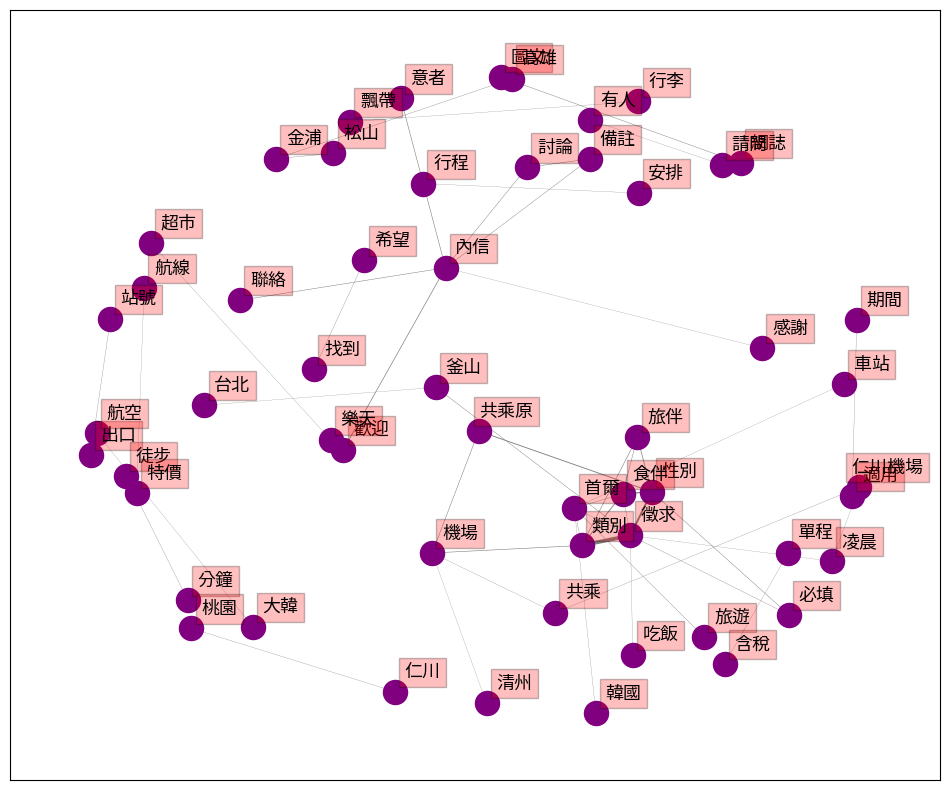

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

由這張圖可以看出，徵求常常跟類別、食伴、旅伴、性別等詞彙一起出現。

## Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [ ]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
7122,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,徵求 類別 行李箱 性別 徵求 拿錯 行李箱 搭乘 行李箱 當日 老婆 晚去 行李 轉盤 行...
7123,7124,https://www.ptt.cc/bbs/Korea_Travel/M.16855505...,[徵求]6/16釜山(廣安里)食伴,2023-06-01,Korea_Travel,徵求類別：食伴\n 原PO性別：女， 2n\n 徵 求：6/16 一起在廣安里吃晚餐\...,徵求類別食伴原性別女徵求一起在廣安里吃晚餐內容當天點左右落地住宿在廣安里所以想找當天可以一起...,徵求 類別 食伴 性別 徵求 廣安 晚餐 當天 落地 住宿 廣安 當天 晚餐 朋友 廣安 更...
7124,7125,https://www.ptt.cc/bbs/Korea_Travel/M.16856058...,[徵求]visitbusanpass實體卡24H4張,2023-06-01,Korea_Travel,徵visit busan pass 實體卡\n24H 4張 捷運站可面交 謝謝\n,徵實體卡張捷運站可面交謝謝,實體 卡張 捷運 面交


In [ ]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一日遊,一隻,下車,不錯,中午,中文,交通,人數,仁川,仁川機場,...,風景,飛機,食伴,飯店,飲料,餐廳,首爾,體驗,高雄,麻煩
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一日遊,一隻,下車,不錯,中午,中文,交通,人數,仁川,...,風景,飛機,食伴,飯店,飲料,餐廳,首爾,體驗,高雄,麻煩
0,一日遊,1.000000,-0.002469,0.314548,0.107691,0.020147,0.195132,0.066591,0.129364,-0.024473,...,0.066264,-0.001116,-0.031318,0.041439,0.045085,0.144037,0.124072,0.208454,-0.013454,0.061194
1,一隻,-0.002469,1.000000,-0.019425,0.073478,0.071446,0.059953,-0.014552,0.004822,-0.024250,...,-0.018582,-0.002519,0.084022,0.011154,0.008274,0.066760,0.138152,0.042889,-0.019793,-0.007304
2,下車,0.314548,-0.019425,1.000000,0.080467,0.017312,0.430122,0.222123,0.020863,-0.005905,...,0.250017,0.184520,-0.049362,0.103378,0.191620,0.196701,-0.029191,0.082249,-0.013763,-0.024842
3,不錯,0.107691,0.073478,0.080467,1.000000,0.028523,0.319288,0.027691,0.017396,-0.006423,...,0.099868,0.017191,-0.022902,0.332986,0.183391,0.093190,0.268524,0.150681,-0.006602,0.054853
4,中午,0.020147,0.071446,0.017312,0.028523,1.000000,0.139735,0.111975,0.089571,-0.035124,...,0.100523,0.037852,0.054736,0.014801,0.059777,0.060928,0.034608,0.025167,-0.028536,0.021205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,餐廳,0.144037,0.066760,0.196701,0.093190,0.060928,0.123715,0.115593,0.049087,-0.052926,...,0.334518,0.071580,0.045891,0.140335,0.085130,1.000000,0.154083,0.088438,-0.037517,-0.036781
296,首爾,0.124072,0.138152,-0.029191,0.268524,0.034608,0.119928,0.190329,0.004578,0.099587,...,-0.005393,0.021885,0.015953,0.130018,0.055772,0.154083,1.000000,0.134205,0.076545,0.000038
297,體驗,0.208454,0.042889,0.082249,0.150681,0.025167,0.193948,0.091357,0.128176,-0.020305,...,0.143144,0.100907,-0.059001,0.119210,0.217433,0.088438,0.134205,1.000000,-0.029178,0.012746
298,高雄,-0.013454,-0.019793,-0.013763,-0.006602,-0.028536,0.027134,-0.004978,-0.020787,0.432131,...,-0.020558,-0.001706,-0.050247,-0.015880,-0.019426,-0.037517,0.076545,-0.029178,1.000000,-0.025198


In [ ]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
64690,爾塔,纜車,0.952477
57215,纜車,爾塔,0.952477
64543,南山,纜車,0.921552
13115,纜車,南山,0.921552
86813,性別,類別,0.921021
34189,類別,性別,0.921021
57043,南山,爾塔,0.888076
13090,爾塔,南山,0.888076
64603,廣場,纜車,0.880131
31115,纜車,廣場,0.880131


### 和 「纜車」, 「首爾」 相關性最高的 10 個詞彙

In [ ]:
car_sum = word_cor_df[(word_cor_df["word1"] == "纜車")].sort_values(by = ['cor'], ascending = False).head(10)
seoul_sum = word_cor_df[(word_cor_df["word1"] == "首爾")].sort_values(by = ['cor'], ascending = False).head(10)

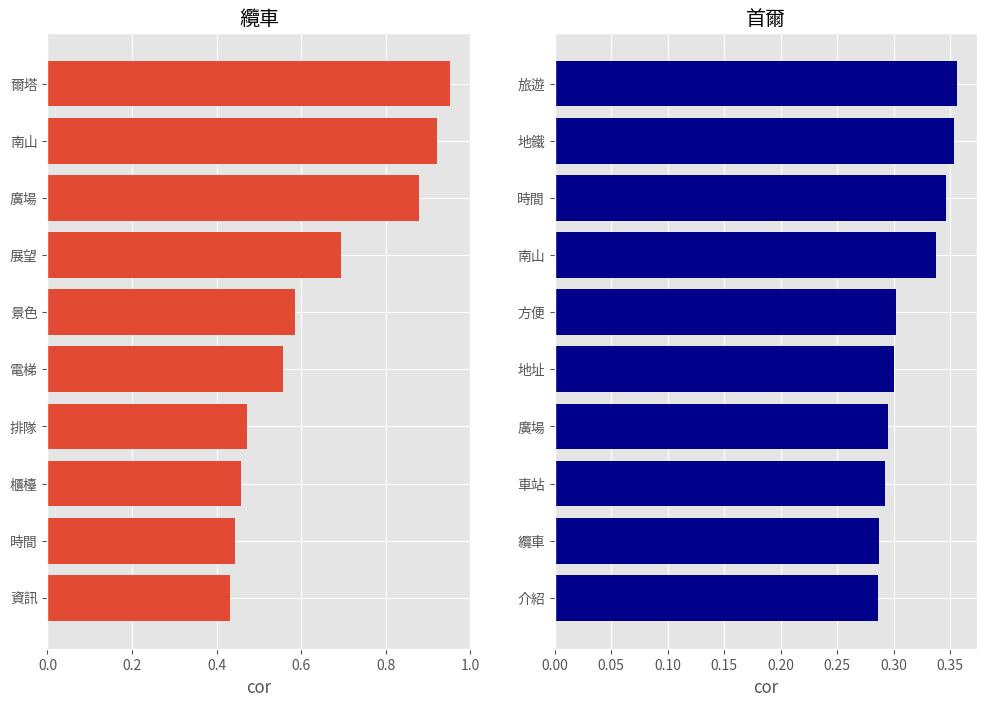

In [ ]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('纜車')
plt.xlabel('cor')
plt.barh(car_sum['word2'], car_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title("首爾")
plt.xlabel('cor')
plt.barh(seoul_sum['word2'], seoul_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

由這張圖可以看出，纜車相關性高的詞彙大多都是纜車所在地點和營業資訊。首爾的部分則是跟交通有關的詞彙居多。

### 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [ ]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [ ]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,喜歡,不錯,0.322073
1,好吃,不錯,0.456066
2,飯店,不錯,0.332986
3,台北,仁川,0.352757
4,航線,仁川,0.549755
...,...,...,...
165,方便,飯店,0.304705
166,推薦,餐廳,0.326817
167,方便,首爾,0.301642
168,旅遊,首爾,0.356211


In [ ]:
# Create network plot
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])

# 取得edge權重
weights = [w[2]['weight']*1 for w in  g.edges(data=True)]

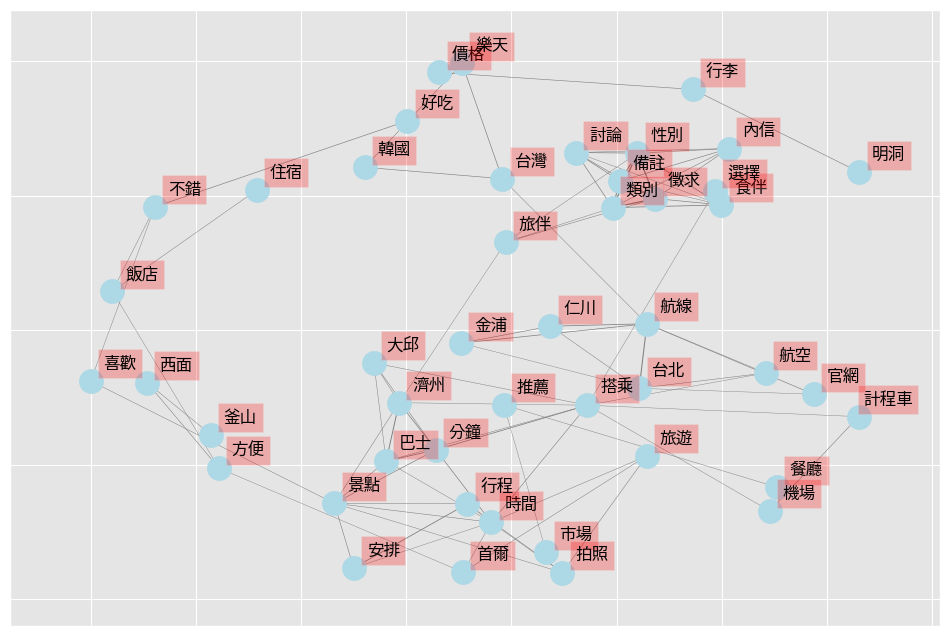

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.5)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()

## 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [ ]:
data_cos = data_cor.copy()
data_cos = data_cos.reset_index()
data_cos = data_cos.drop(['index'], axis = 1)
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,7123,https://www.ptt.cc/bbs/Korea_Travel/M.16855501...,[徵求]5/31濟州航空7C2602拿錯行李的人,2023-06-01,Korea_Travel,徵求類別：行李箱\n 原PO性別：不拘\n 徵 求：拿錯行李箱的人\n 內 容：\...,徵求類別行李箱原性別不拘徵求拿錯行李箱的人內容搭乘的人有拿錯行李箱的嗎當日我跟我老婆比較晚去...,徵求 類別 行李箱 性別 徵求 拿錯 行李箱 搭乘 行李箱 當日 老婆 晚去 行李 轉盤 行...
1,7124,https://www.ptt.cc/bbs/Korea_Travel/M.16855505...,[徵求]6/16釜山(廣安里)食伴,2023-06-01,Korea_Travel,徵求類別：食伴\n 原PO性別：女， 2n\n 徵 求：6/16 一起在廣安里吃晚餐\...,徵求類別食伴原性別女徵求一起在廣安里吃晚餐內容當天點左右落地住宿在廣安里所以想找當天可以一起...,徵求 類別 食伴 性別 徵求 廣安 晚餐 當天 落地 住宿 廣安 當天 晚餐 朋友 廣安 更...
2,7125,https://www.ptt.cc/bbs/Korea_Travel/M.16856058...,[徵求]visitbusanpass實體卡24H4張,2023-06-01,Korea_Travel,徵visit busan pass 實體卡\n24H 4張 捷運站可面交 謝謝\n,徵實體卡張捷運站可面交謝謝,實體 卡張 捷運 面交


In [ ]:
transformer = TfidfTransformer()
print(transformer)
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一日遊,一隻,下車,不錯,中午,中文,交通,人數,仁川,仁川機場,...,風景,飛機,食伴,飯店,飲料,餐廳,首爾,體驗,高雄,麻煩
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.130116,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,0.0,0.0,0.0,0.0,0.0,0.0,0.304146,0.0,0.262153,0.0,...,0.0,0.0,0.000000,0.238787,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
943,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


計算文章間的cosine similarity

In [ ]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第二篇文章相似的文章

In [ ]:
cos_df = pd.DataFrame(cosine_matrix[1], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,0.064506
1,1.000000
2,0.000000
3,0.032906
4,0.022946
...,...
940,0.013193
941,0.140124
942,0.000000
943,0.191196


In [ ]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
1,1.000000,[徵求]6/16釜山(廣安里)食伴,https://www.ptt.cc/bbs/Korea_Travel/M.16855505...
344,0.599012,[住宿]釜山｜HotelCentralBay。廣安夢幻海景飯店,https://www.ptt.cc/bbs/Korea_Travel/M.16919175...
118,0.590686,[徵求]7/2-7/3海雲台、廣安里食伴,https://www.ptt.cc/bbs/Korea_Travel/M.16876931...
128,0.567141,[遊記]釜山｜CUP&CUP咖啡。收盡廣安里全幅海景,https://www.ptt.cc/bbs/Korea_Travel/M.16878602...
175,0.511611,[遊記]釜山｜山海餐廳。廣安里豪景生魚總匯食堂,https://www.ptt.cc/bbs/Korea_Travel/M.16885149...
41,0.416270,[徵求]6/17-6/20釜山食伴,https://www.ptt.cc/bbs/Korea_Travel/M.16862249...
95,0.395644,[遊記]釜山｜廣安里海景滿喫的鮮貝總匯刀削麵,https://www.ptt.cc/bbs/Korea_Travel/M.16873072...
203,0.386685,[徵求]7/18-7/22釜山食伴/旅伴,https://www.ptt.cc/bbs/Korea_Travel/M.16890561...
348,0.362899,[徵求]9/30-10/1食伴,https://www.ptt.cc/bbs/Korea_Travel/M.16919387...
451,0.361330,9/21-9/22釜山旅伴&食伴,https://www.ptt.cc/bbs/Korea_Travel/M.16951400...


第二篇文章是在徵求釜山食伴的文章，所以可以看到相關的文章大多也都是徵求食伴以及釜山相關的文章

檢視與第47篇文章相似的文章

In [ ]:
cos_df_14 = pd.DataFrame(cosine_matrix[46], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_14.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
46,1.000000,[遊記]首爾出發的南怡島一日遊行程,https://www.ptt.cc/bbs/Korea_Travel/M.16863017...
432,0.588633,[問題]南怡島行程搭配,https://www.ptt.cc/bbs/Korea_Travel/M.16949195...
518,0.524633,[問題]冬季行程青陽冰柱噴泉vseobi冰谷,https://www.ptt.cc/bbs/Korea_Travel/M.16963824...
618,0.497335,[徵求]11/27南怡島/加平鐵道/晨靜樹木園一日遊,https://www.ptt.cc/bbs/Korea_Travel/M.16980332...
231,0.474041,[問題]雪嶽山要自己去還是報kkday的一日遊?,https://www.ptt.cc/bbs/Korea_Travel/M.16895750...
194,0.470069,[問題]Klook首爾近郊一日遊選擇,https://www.ptt.cc/bbs/Korea_Travel/M.16888307...
489,0.427447,[問題]首爾兩日行程挑選請益,https://www.ptt.cc/bbs/Korea_Travel/M.16958822...
643,0.392412,[徵求]11/11京畿道一日遊旅伴（南怡島+晨靜,https://www.ptt.cc/bbs/Korea_Travel/M.16984178...
234,0.365584,[規畫]第一次去韓國跪求必去景點,https://www.ptt.cc/bbs/Korea_Travel/M.16895911...
729,0.324609,[問題]klook/kkday包車的南怡島行程,https://www.ptt.cc/bbs/Korea_Travel/M.16997175...


第47篇文章主要是在分享南怡島的旅遊行程，所以相關性較高的文章也都是在撰寫南怡島相關的行程居多。